In [1]:
%matplotlib inline

In [2]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from unicode_codes import EMOJI_UNICODE
sns.set(style="white")
from twitter_search_funcs import smoothed_relative_freq

In [3]:
print(sys.version)

3.6.4 (default, Mar  7 2018, 12:11:36) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


## Data load and clean

In [4]:
# Load data for all years
list_a = []
list_l = []
list_e = []
totals = {}

for year in [2014, 2015, 2016]:
    df_a = pd.read_csv("./data/alldata_{}_repeat.csv".format(year), index_col=0)
    df_l = pd.read_csv("./data/langdata_{}_repeat.csv".format(year), index_col=0)
    df_e = pd.read_csv("./data/allemojidata_{}_repeat.csv".format(year), index_col=0)
    df_a['Year'], df_l['Year'], df_e['Year'] = year, year, year
    list_a.append(df_a)
    list_l.append(df_l)
    list_e.append(df_e)
    
    totals[year] = {}
    with open("./data/log_{}_repeat.txt".format(year)) as f:
        f.readline()
        totals[year]['total_tweets'] = f.readline().strip().split()[-1]
        totals[year]['total_tweets_wEmoji'] = f.readline().strip().split()[-1]
        totals[year]['total_matches'] = f.readline().strip().split()[-1]
        totals[year]['total_wBefore'] = f.readline().strip().split()[-1]
        totals[year]['total_wAfter'] = f.readline().strip().split()[-1]

df_totals = pd.DataFrame.from_dict(totals, orient='index', dtype=int)
df_all = pd.concat(list_a).join(df_totals, how='left', on='Year')
df_lang = pd.concat(list_l)
df_allemoji = pd.concat(list_e).join(df_totals, how='left', on='Year')

emojiCount = df_allemoji.groupby('Year').Count.sum().rename('total_emoji', inplace=True)
df_allemoji = df_allemoji.join(emojiCount, how='left', on='Year')

In [5]:
# Find percentages of before matches, percentages of after matches, and count per million of total tweets searched
df_all['PercentBefore'] = 100. * df_all['CountBefore'] / df_all['total_wBefore']
df_all['PercentAfter'] = 100. * df_all['CountAfter'] / df_all['total_wAfter']

df_all['PPMBefore'] = 1e6 * df_all['CountBefore'] / df_all['total_tweets']
df_all['PPMAfter'] = 1e6 * df_all['CountAfter'] / df_all['total_tweets']

df_allemoji['Percent'] = 100. * df_allemoji['Count'] / df_allemoji['total_emoji']
df_allemoji['PPM'] = 1e6 * df_allemoji['Count'] / df_allemoji['total_tweets']

In [6]:
# Merge total counts into df_all
drop_cols = ['total_tweets', 'total_tweets_wEmoji', 'total_matches', 'total_wBefore', 'total_wAfter']

df_all_merged = df_all.merge(df_allemoji.drop(drop_cols, axis=1),
                             on=['Emoji', 'Year'],
                             how='outer')

In [7]:
# Add smoothed relative frequencies to df_all_merged
for N in [1, 100, 10000, 1000000]:
    logN = np.log10(N)
    df_all_merged['Score{:.0f}_Bef'.format(logN)] = smoothed_relative_freq(
                                                        df_all_merged.CountBefore,
                                                        df_all_merged.Count,
                                                        df_all_merged.total_wBefore,
                                                        df_all_merged.total_emoji,
                                                        N=N)
    df_all_merged['Score{:.0f}_Aft'.format(logN)] = smoothed_relative_freq(
                                                        df_all_merged.CountAfter,
                                                        df_all_merged.Count,
                                                        df_all_merged.total_wAfter,
                                                        df_all_merged.total_emoji,
                                                        N=N)

In [8]:
# Add errors
df_all_merged['PPMBefore_err'] = (df_all_merged.PPMBefore * np.sqrt(df_all_merged.CountBefore)
    / df_all_merged.CountBefore)
df_all_merged['PPMAfter_err'] = (df_all_merged.PPMAfter * np.sqrt(df_all_merged.CountAfter)
    / df_all_merged.CountAfter)

In [9]:
df_all_merged['Score2_Bef_err'] = df_all_merged.Score2_Bef * np.sqrt((np.sqrt(df_all_merged.CountBefore)
                                                                      / df_all_merged.CountBefore)**2
                                                                   + (np.sqrt(df_all_merged.Count)
                                                                      / df_all_merged.Count)**2)
df_all_merged['Score2_Aft_err'] = df_all_merged.Score2_Aft * np.sqrt((np.sqrt(df_all_merged.CountAfter)
                                                                      / df_all_merged.CountAfter)**2
                                                                   + (np.sqrt(df_all_merged.Count)
                                                                      / df_all_merged.Count)**2)

In [10]:
df_all_merged['PPM_err'] = (df_all_merged.PPM * np.sqrt(df_all_merged.Count)
    / df_all_merged.Count)

In [11]:
pd.options.display.float_format = '{:.2f}'.format
df_all_merged.head()

,Emoji,CountBefore,CountAfter,Year,total_tweets,total_tweets_wEmoji,total_matches,total_wBefore,total_wAfter,PercentBefore,...,Score2_Aft,Score4_Bef,Score4_Aft,Score6_Bef,Score6_Aft,PPMBefore_err,PPMAfter_err,Score2_Bef_err,Score2_Aft_err,PPM_err
0,😊,1246.00,88.00,2014,141266004.00,17774137.00,82973.00,48893.00,27566.00,2.55,...,0.28,1.63,0.61,1.01,0.99,0.25,0.07,0.06,0.03,5.35
1,🌚,397.00,165.00,2014,141266004.00,17774137.00,82973.00,48893.00,27566.00,0.81,...,2.20,1.43,1.26,1.01,1.00,0.14,0.09,0.15,0.17,2.56
2,💰,253.00,241.00,2014,141266004.00,17774137.00,82973.00,48893.00,27566.00,0.52,...,3.67,1.23,1.52,1.00,1.01,0.11,0.11,0.14,0.24,2.38
3,💥,2258.00,311.00,2014,141266004.00,17774137.00,82973.00,48893.00,27566.00,4.62,...,2.57,3.92,1.49,1.04,1.01,0.34,0.12,0.22,0.15,3.26
4,🙌,112.00,66.00,2014,141266004.00,17774137.00,82973.00,48893.00,27566.00,0.23,...,0.25,0.62,0.63,0.99,0.99,0.07,0.06,0.02,0.03,4.90


In [12]:
# Filter and sort dataframes by counts
filter_to = 200
df_topbefore = df_all_merged.groupby('Year').apply(lambda x: x.nlargest(filter_to, columns='CountBefore'))
df_topafter = df_all_merged.groupby('Year').apply(lambda x: x.nlargest(filter_to, columns='CountAfter'))
df_top = df_all_merged.groupby('Year').apply(lambda x: x.nlargest(filter_to, columns='Count'))

## Tables

In [13]:
year = 2016

In [14]:
pd.options.display.float_format = '{:.0f}'.format
df_topafter.loc[year, :'Year'].head(8)

,Emoji,CountBefore,CountAfter,Year
1748,🔫,nan,5052,2016
1241,🔪,614,735,2016
1235,💣,450,601,2016
1225,😂,3135,569,2016
1258,😎,153,242,2016
1230,💥,1197,224,2016
1272,🔥,222,207,2016
1236,😭,2096,195,2016


In [15]:
pd.options.display.float_format = '{:.0f}'.format
df_topbefore.loc[year, :'Year'].head(8)

,Emoji,CountBefore,CountAfter,Year
1225,😂,3135,569,2016
1236,😭,2096,195,2016
1230,💥,1197,224,2016
1248,😊,767,48,2016
1228,🙃,680,25,2016
1241,🔪,614,735,2016
1252,😒,516,89,2016
1271,😩,503,32,2016


In [16]:
pd.options.display.float_format = '{:.0f}'.format
df_top.loc[year, :'Year'].head(8)

,Emoji,CountBefore,CountAfter,Year
1225,😂,3135,569,2016
1278,❤,117,97,2016
1236,😭,2096,195,2016
1282,😍,281,81,2016
1281,💕,217,106,2016
1446,✨,16,38,2016
1316,🏻,168,nan,2016
1272,🔥,222,207,2016


In [17]:
pd.options.display.float_format = '{:.2f}'.format
cols = ['Emoji', 'CountBefore', 'CountAfter', 'Year', 'Score2_Bef']
df_topbefore.loc[year][cols].sort_values('Score2_Bef', ascending=False).head(8)

,Emoji,CountBefore,CountAfter,Year,Score2_Bef
1241,🔪,614.00,735.00,2016,35.32
1235,💣,450.00,601.00,2016,27.00
1428,🃏,55.00,10.00,2016,15.54
1230,💥,1197.00,224.00,2016,13.35
1301,🐔,73.00,6.00,2016,12.27
1289,☠,66.00,58.00,2016,10.83
1385,🗡,31.00,51.00,2016,9.75
1373,👮,53.00,46.00,2016,9.71


In [18]:
pd.options.display.float_format = '{:.2f}'.format
cols = ['Emoji', 'CountAfter', 'CountBefore', 'Year', 'Score2_Aft']
df_topafter.loc[year][cols].sort_values('Score2_Aft', ascending=False).head(8)

,Emoji,CountAfter,CountBefore,Year,Score2_Aft
1748,🔫,5052.00,nan,2016,305.33
1241,🔪,735.00,614.00,2016,80.08
1235,💣,601.00,450.00,2016,68.21
1385,🗡,51.00,31.00,2016,28.98
1511,⚰,66.00,4.00,2016,26.18
1424,💂,54.00,11.00,2016,21.68
1289,☠,58.00,66.00,2016,17.81
1438,🔨,36.00,33.00,2016,17.05


## Plots

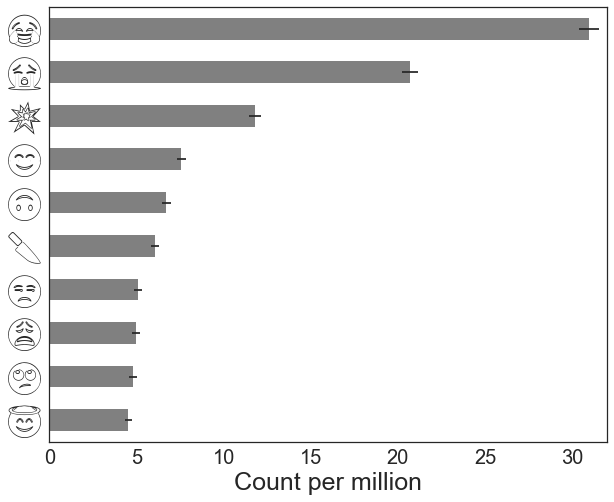

In [19]:
df_topbefore.loc[year].iloc[:10] \
            .sort_values('CountBefore', ascending=True) \
            .plot.barh(x='Emoji',
                       y='PPMBefore',
                       xerr='PPMBefore_err',
                       figsize=(10,8),
                       legend=False,
                       xlim=(0,32),
                       color='grey')
#plt.title('Emoji Appearing Before the Gun Emoji', fontsize=30)
plt.yticks(fontsize=35, fontname='Twitter Color Emoji', rotation='horizontal')
plt.xticks(fontsize=20)
plt.ylabel('')
plt.xlabel('Count per million', fontsize=25)
plt.savefig('images/before-bar-10-print.pdf', bbox_inches='tight')
plt.show()

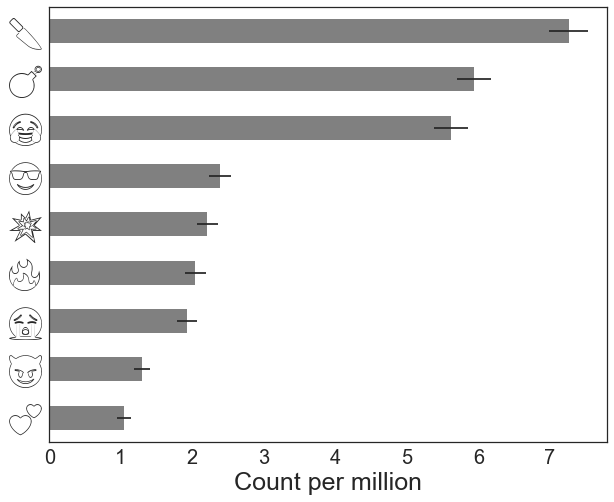

In [20]:
df_topafter.loc[year].iloc[1:10] \
           .sort_values('CountAfter', ascending=True) \
           .plot.barh(x='Emoji',
                      y='PPMAfter',
                      xerr='PPMAfter_err',
                      figsize=(10,8),
                      legend=False,
                      xlim=(0,7.8),
                      color='grey')
#plt.title('Emoji Appearing After the Gun Emoji', fontsize=30)
plt.yticks(fontsize=35, fontname='Twitter Color Emoji', rotation='horizontal')
plt.xticks(fontsize=20)
plt.ylabel('')
plt.xlabel('Count per million', fontsize=25)
plt.savefig('images/after-bar-10-print.pdf', bbox_inches='tight')
plt.show()

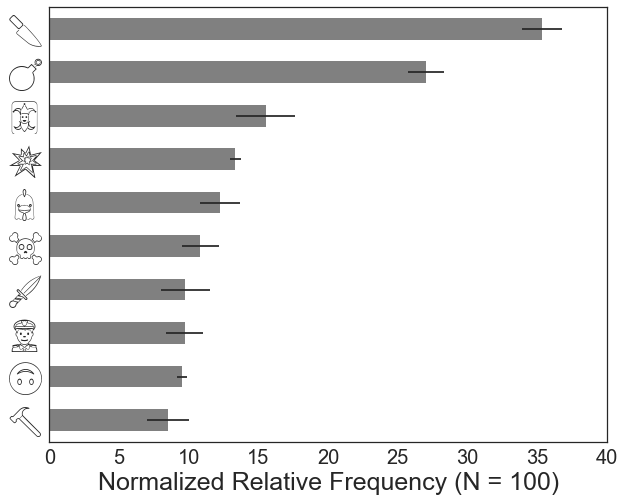

In [21]:
df_topbefore.loc[year] \
            .sort_values('Score2_Bef', ascending=False).iloc[:10] \
            .sort_values('Score2_Bef', ascending=True) \
            .plot.barh(x='Emoji',
                       y='Score2_Bef',
                       xerr='Score2_Bef_err',
                       figsize=(10,8),
                       legend=False,
                       xlim=(0,40),
                       color='grey')
#plt.title('Emoji Appearing Before the Gun Emoji', fontsize=30)
plt.yticks(fontsize=35, fontname='Twitter Color Emoji', rotation='horizontal')
plt.xticks(fontsize=20)
plt.ylabel('')
plt.xlabel('Normalized Relative Frequency (N = 100)', fontsize=25)
plt.savefig('images/before-bar-10-NRF100-print.pdf', bbox_inches='tight')
plt.show()

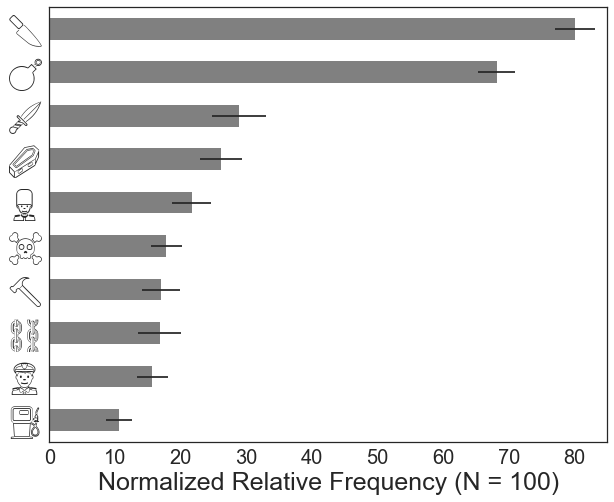

In [22]:
df_topafter.loc[year] \
           .sort_values('Score2_Aft', ascending=False).iloc[1:11] \
           .sort_values('Score2_Aft', ascending=True) \
           .plot.barh(x='Emoji',
                      y='Score2_Aft',
                      xerr='Score2_Aft_err',
                      figsize=(10,8),
                      legend=False,
                      xlim=(0,85),
                      color='grey')
#plt.title('Emoji Appearing After the Gun Emoji', fontsize=30)
plt.yticks(fontsize=35, fontname='Twitter Color Emoji', rotation='horizontal')
plt.xticks(fontsize=20)
plt.ylabel('')
plt.xlabel('Normalized Relative Frequency (N = 100)', fontsize=25)
plt.savefig('images/after-bar-10-NRF100-print.pdf', bbox_inches='tight')
plt.show()

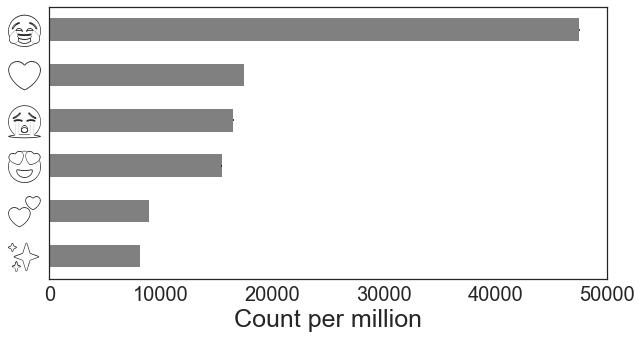

In [23]:
df_top.loc[year] \
      .sort_values('PPM', ascending=False).iloc[:6] \
      .sort_values('PPM', ascending=True) \
      .plot.barh(x='Emoji',
                 y='PPM',
                 xerr='PPM_err',
                 figsize=(10,5),
                 legend=False,
                 xlim=(0,50000),
                 color='grey')
#plt.title('Total Emoji Counts', fontsize=30)
plt.yticks(fontsize=35, fontname='Twitter Color Emoji', rotation='horizontal')
plt.xticks(fontsize=20)
plt.ylabel('')
plt.xlabel('Count per million', fontsize=25)
plt.savefig('images/total-6-print.pdf', bbox_inches='tight')
plt.show()